In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from polygon import RESTClient
import json
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
client = RESTClient(auth_key="JeeOjlOPBe5aTiQ_Jb39raRqlam45uAO")

def getTickerDailyData(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print("Starting data pull for {}".format(ticker))
    data = []
    date_range = pd.date_range(start, end, freq='B')
    for business_day in date_range:
        try:
            response = client.stocks_equities_daily_open_close(symbol=ticker, date=str(business_day)[0:10])
            data.append([pd.to_datetime(response.from_) ,response.open, response.close, response.high, response.low, ticker])
        except:
            continue
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])

In [3]:
ezpw_data = getTickerDailyData(client, ticker="EZPW", start="2018-01-01", end="2023-02-01")

Starting data pull for EZPW


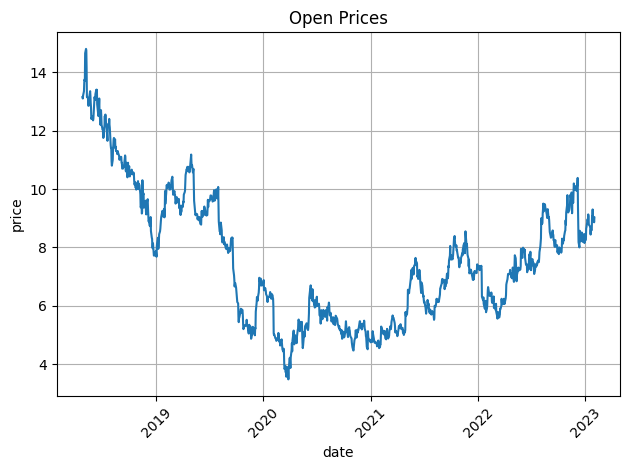

In [4]:
fig, ax = plt.subplots()
ax.plot(ezpw_data.date.values, ezpw_data.open.values)

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

 Build Model

Our first model, will be a SA-ARISMA model using only the series itself, predicting one day in advance then incorporating that data into its next daily prediction. Seasonally Adjusted, Autoregressive, Integrated, Simple moving average model. 

In [5]:
ezpw_data.head()

ezpw_data_open = ezpw_data[['date', 'open', 'ticker']]

In [6]:
ezpw_data_open.head()

,date,open,ticker
0,2018-04-25,13.150,EZPW
1,2018-04-26,13.100,EZPW
2,2018-04-27,13.200,EZPW
3,2018-04-30,13.350,EZPW
4,2018-05-01,13.650,EZPW


In [7]:
ezpw_data_open["ar1"] = ezpw_data_open['open'].shift(1)
ezpw_data_open["ar2"] = ezpw_data_open['open'].shift(2)
ezpw_data_open["ar3"] = ezpw_data_open['open'].shift(3)
ezpw_data_open["ar4"] = ezpw_data_open['open'].shift(4)
ezpw_data_open["SMA"] = ezpw_data_open['ar1'].rolling(5).mean()
ezpw_data_open["int"] = ezpw_data_open.ar1 - ezpw_data_open.ar2
ezpw_data_open['intercept'] = np.ones(len(ezpw_data_open))

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_13291/3655870408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ezpw_data_open["ar1"] = ezpw_data_open['open'].shift(1)
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_13291/3655870408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ezpw_data_open["ar2"] = ezpw_data_open['open'].shift(2)


In [ ]:
ezpw_data_open.head()

In [ ]:
ezpw_data_open.shape

In [ ]:
train_data = ezpw_data_open[5:500]

In [ ]:
train_data.head()

In [ ]:
reg = LinearRegression()

In [ ]:
fit_model = reg.fit(train[['ar1','ar2', 'SMA', 'int']], train_data[['open']])

In [ ]:
fit_model.coef_

In [ ]:
fit_model.intercept_

In [ ]:
fit_model.get_params()

In [ ]:
train_data['prediction_insample'] = fit_model.predict(train_data[['ar1','ar2', 'SMA', 'int']])

In [ ]:
train_data.head()

In [ ]:
train_data['error'] = train_data.open - train_data.prediction_insample
train_data['sq_error'] = train_data['error']**2
train_data['abs_error'] = np.abs(train_data['error'])

In [ ]:
train_data

In [ ]:
train_data[['error', 'sq_error', 'abs_error']].mean()

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_data.date.values[:20], train_data.open.values[:20])
ax.plot(train_data.date.values[:20], train_data.prediction_insample.values[:20])

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
test_data = ezpw_data_open[500:]

In [ ]:
test_data

In [ ]:
test_data['prediction_oos'] = fit_model.predict(test_data[['ar1','ar2', 'SMA', 'int']])

In [ ]:
test_data.head()

In [ ]:
test_data['error'] = test_data.open - test_data.prediction_oos
test_data['sq_error'] = test_data['error']**2
test_data['abs_error'] = np.abs(test_data['error'])

In [ ]:
test_data

In [ ]:
test_data[['error', 'sq_error', 'abs_error']].mean()

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_data.date.values[:20], test_data.open.values[:20])
ax.plot(test_data.date.values[:20], test_data.prediction_oos.values[:20])

ax.set(xlabel='date', ylabel='price', title="Open Prices")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
fit_model2 = reg.fit(test_data[['ar1','ar2', 'SMA', 'int']], test_data[['open']])

In [ ]:
test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])

In [ ]:
test_data

In [ ]:
test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
test_data['in_sample_abs_error'] = np.abs(test_data['in_sample_error'])

In [ ]:
test_data[['in_sample_error', 'in_sample_sq_error', 'in_sample_abs_error']].mean()